In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import gc
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler,LabelEncoder
from sklearn.linear_model import SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from dateutil import parser
from swifter import swifter #для параллельной обработки статистик и OLS
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
sensors=pd.read_csv('sensors.csv', index_col="timestamp", parse_dates=["timestamp"])
num_col=[col for col in sensors.columns if sensors[col].dtype!=object]

In [5]:
TR_END = "2017-12-31 23:00:00"
sensors.ffill(inplace=True)
sensors.fillna(sensors[:TR_END].mean(), inplace=True)
sensors[num_col]=sensors[num_col].applymap(lambda x:x if x>=0 else 0)

In [6]:
tags=pd.read_csv('tags.csv')

In [7]:
y_coke=pd.read_csv('coke_target.csv', index_col="timestamp", parse_dates=["timestamp"])

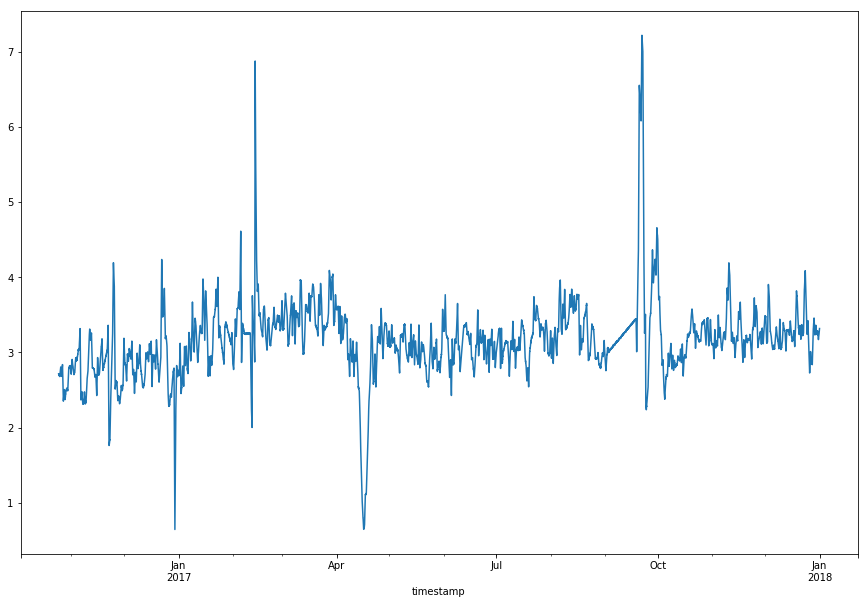

In [8]:
plt.figure(figsize=(15,10))
y_coke.target.plot()

In [9]:
coke_subm=pd.read_csv('coke_sample_submission.csv')

### EDA

In [10]:
corr_data=sensors.merge(y_coke, on='timestamp', how='inner').corr()

In [11]:
import seaborn as sns

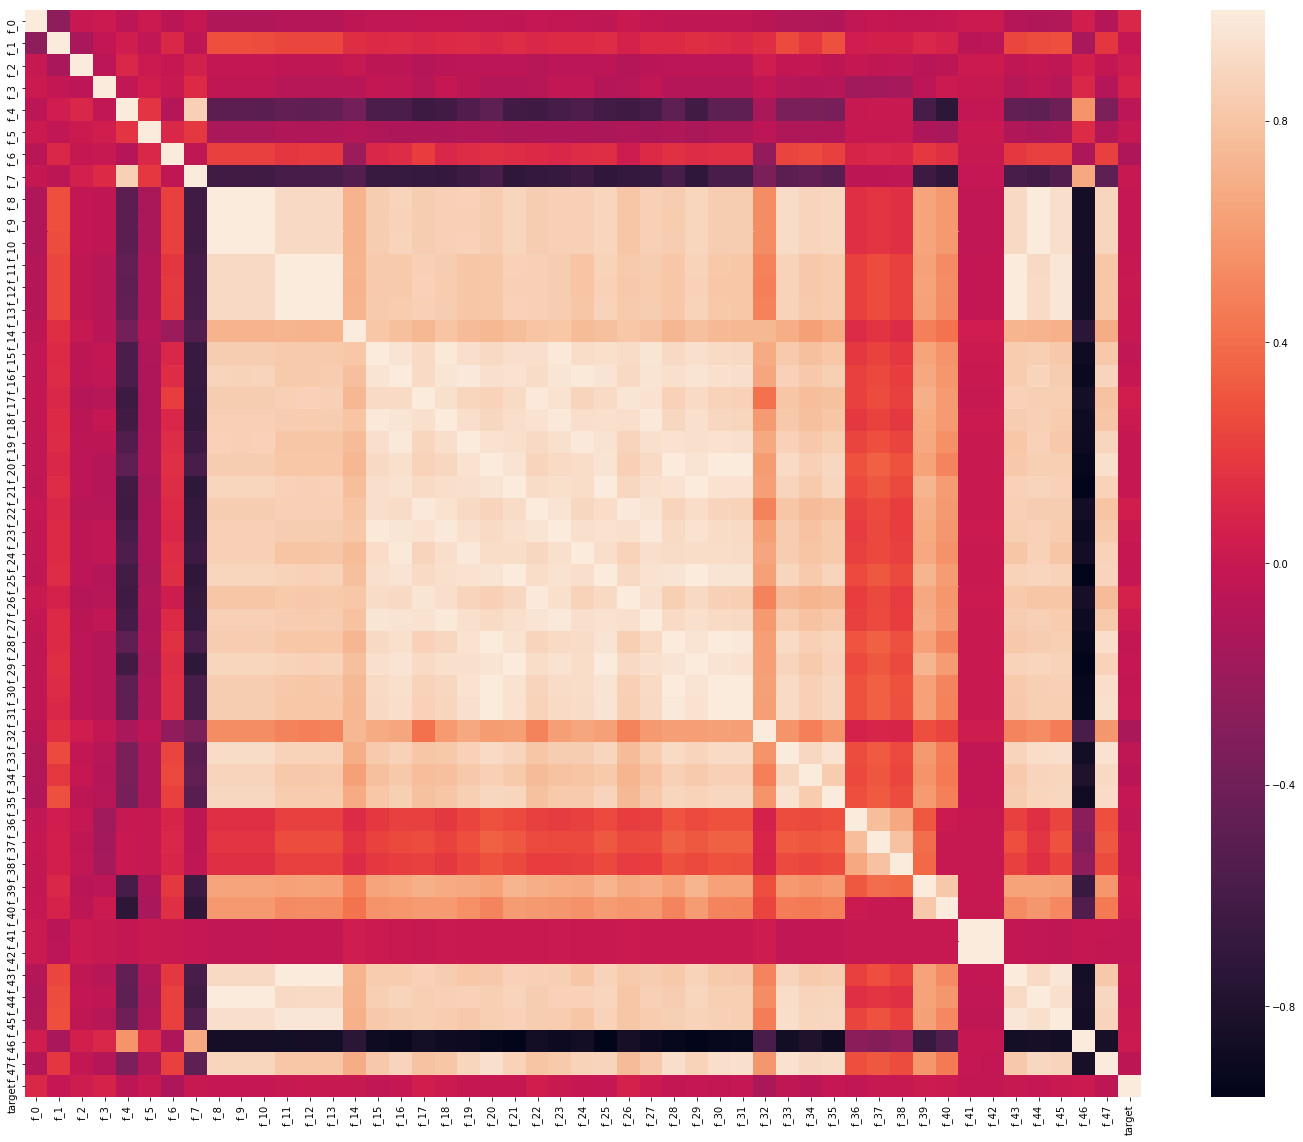

In [12]:
plt.figure(figsize=(25,20))
sns.heatmap(corr_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000197E1E3B8D0>]],
      dtype=object)

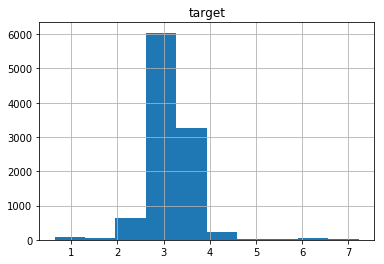

In [76]:
y_coke.hist()

In [77]:
rf=RandomForestRegressor(n_estimators=100, n_jobs=4)

In [78]:
x_start=sensors[num_col].merge(y_coke, how='inner', on='timestamp')

In [79]:
rf.fit(x_start[num_col], x_start.target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

(-1, 48)

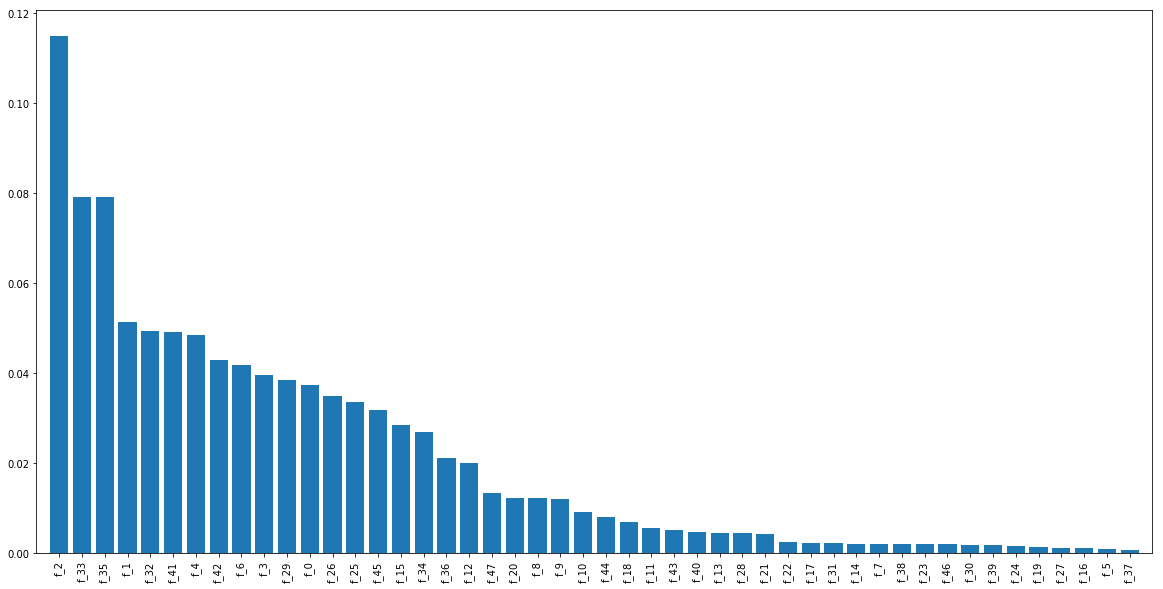

In [80]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
d_first =x_start[num_col].shape[1]
rf_col=x_start[num_col].columns[indices[:d_first]]
plt.figure(figsize=(20, 10))
#plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(x_start[num_col].columns)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first])

In [81]:
imp_col=x_start[num_col].columns[indices[importances>=0.01]]

### ИДЕИ

3. Делать лаги по переменным не целевым - лаг найти +
4. Искать целевую переменную по ближ соседу - было в бейзлайне
5. Бинарные переменные перекодировать +
6. timestamp-как вариант получения признаков- часть суток, время года, день недели, тип дня недели и тп +
8. Недельный тренд, суточный тренд (неделя = 7*24), stats=min max mean std, ols +
9. Средние по дням недели (пн вт ср чт пт и тп), ср в раб.день, ср. в вых день, (weekday) +
11. Предсказывать не час в час а за час два три 4 6 12 до целевого процесса!!!! + но не пашет
12. Сделать просто шифт по датчикам +

### Производные фичи

1. Восстановление пропусков исходя из сути переменных +
2. Отношения / разности между последовательно расположенными объектами +
3. OLS на таких данных (последовательно) +
4. Не забыть доли от общих фич. +
5. Прогнзирование дисперсии/пиков +-
6. прогнозы пиков-как прогнозы остановок - пробовал не взлетело

In [70]:
import statsmodels.api as sm #Импортируем модуль статс для расчета трендов в временных рядах за n прошедших дней

In [14]:
#тут стандартизируем данные и считаем регрессию , в качестве ответа выдаем tg(alpha) угла наклона тренда 
#(или тоже что и производная)
def ols_res(x):
    res=sm.OLS((x-x.mean())/x.std(), np.arange(len(x))).fit()
    return res.params[0]

In [15]:
#Выделим все фичи по группам коррелирующих признаков

etilen_col=['f_1', 'f_2'] #f2 делим на f_0
comp_col=['f_3', 'f_4', 'f_5','f_6']

consump_etan_abc=['f_8','f_9','f_10']
consump_rec_gas_abc=['f_11','f_12','f_13']

consump_r1_r3=['f_14', 'f_17', 'f_22']
consump_m1_m4=['f_15','f_18','f_23','f_27']
consump_v1_v4=['f_16','f_19','f_24', 'f_26']

temp_r1_r4=['f_30','f_20','f_31','f_28']
temp_h1_h4=['f_21','f_25', 'f_29']

consump_SO_nas1_3=['f_33','f_34', 'f_35'] #делим на f_32 каждый - общий расход

v_nas_1_4=['f_36','f_37', 'f_38', 'f_39']

consump_etil_etan=['f_41', 'f_42'] #делим на consump_etan и разницу ищем

consump_compr=['f_43', 'f_44', 'f_45'] #делим на f_47 и делаем разницы и парты между ними

#сведем колонки связанные или расположением объектов производства или с корреляцией показаний в один массив фич
#далее этот массив мы будем использовать для расчетов производных от признаков фич-трендов, статистик и отношений/разностей
#после эти производные признаки мы используем вместо скоррелированных

diff_col=(
          consump_compr+consump_etil_etan
          +etilen_col+comp_col+consump_etan_abc
          +consump_rec_gas_abc+consump_r1_r3+consump_m1_m4
          +consump_v1_v4+temp_r1_r4+temp_h1_h4+consump_SO_nas1_3+v_nas_1_4
         )
#так же запомним остальные не скоррелированные фичи их тоже добавим в модель
other_col=[col for col in num_col if col not in diff_col]

In [16]:
#темпы роста/падения последовательно/параллельно размещенного оборудования
def get_diff_temp(data, cols, new_cols): 
    for i in range(len(cols)-1):
        data[cols[i+1]+'/'+cols[i]]=data[cols[i+1]]/(1+data[cols[i]])
        new_cols.append(cols[i+1]+'/'+cols[i])
        data[cols[i+1]+'-'+cols[i]]=data[cols[i+1]]-data[cols[i]]
        new_cols.append(cols[i+1]+'-'+cols[i])

In [17]:
#нахождения отношений по правилу "всё со всеми"
def get_part(data, cols, new_cols): 
    taboo=[]
    for col1 in cols:
        taboo.append(col1)
        for col2 in cols:
            if col1!=col2 and col2 not in taboo:
                data[col1+'/'+col2]=data[col1]/(data[col2]+1)
                new_cols.append(col1+'/'+col2)

In [18]:
def get_diff_features(data):
    new_diff_cols=[]
    data['f_7'].ffill(inplace=True) #CO2 доля
    print('etan_col')
    for col in etilen_col:
        data[col+'/etan']=data[col]/(data['f_0']+1)
        new_diff_cols.append(col+'/etan')
    
    get_diff_temp(data, etilen_col, new_diff_cols)
    data['OLS_etilen']=[ols_res(x) for x in np.array(data[etilen_col])]
    new_diff_cols.append('OLS_etilen')
    
    print('comp_col')
    for col in comp_col:
        data[col+'/co2']=data[col]/(data['f_7']+1)
        new_diff_cols.append(col+'/co2')
    get_part(data, comp_col, new_diff_cols)
        
    print('consump_etan_abc')
    data[consump_etan_abc].ffill(inplace=True)
    get_diff_temp(data, consump_etan_abc,new_diff_cols)
    data['OLS_consump_etan_abc']=[ols_res(x) for x in np.array(data[consump_etan_abc])]
    new_diff_cols.append('OLS_consump_etan_abc')
    
    print('consump_rec_gas_abc')
    data[consump_rec_gas_abc].ffill(inplace=True)
    get_diff_temp(data, consump_rec_gas_abc,new_diff_cols)
    data['OLS_consump_rec_gas_abc']=[ols_res(x) for x in np.array(data[consump_rec_gas_abc])]
    new_diff_cols.append('OLS_consump_rec_gas_abc')
    

    print('consump_r1_r3')
    data[consump_r1_r3].ffill(inplace=True)
    get_diff_temp(data, consump_r1_r3,new_diff_cols)
    data['OLS_consump_r1_r3']=[ols_res(x) for x in np.array(data[consump_r1_r3])]
    new_diff_cols.append('OLS_consump_r1_r3')

    print('consump_m1_m4')
    data[consump_m1_m4].ffill(inplace=True)
    get_diff_temp(data, consump_m1_m4,new_diff_cols)
    data['OLS_consump_m1_m4']=[ols_res(x) for x in np.array(data[consump_m1_m4])]
    new_diff_cols.append('OLS_consump_m1_m4')
    
    print('consump_v1_v4')
    data[consump_v1_v4].ffill(inplace=True)
    get_diff_temp(data, consump_v1_v4, new_diff_cols)
    data['OLS_consump_v1_v4']=[ols_res(x) for x in np.array(data[consump_v1_v4])]
    new_diff_cols.append('OLS_consump_v1_v4')
    
    print('temp_r1_r4')
    data[temp_r1_r4].ffill(inplace=True)
    get_diff_temp(data, temp_r1_r4,new_diff_cols)
    data['OLS_temp_r1_r4']=[ols_res(x) for x in np.array(data[temp_r1_r4])]
    new_diff_cols.append('OLS_temp_r1_r4')
    
    print('temp_h1_h4')
    data[temp_h1_h4].ffill(inplace=True)
    get_diff_temp(data, temp_h1_h4,new_diff_cols)
    data['OLS_temp_h1_h4']=[ols_res(x) for x in np.array(data[temp_h1_h4])]
    new_diff_cols.append('OLS_temp_h1_h4')
    
    print('consump_SO_nas1_3')
    data[consump_SO_nas1_3].ffill(inplace=True)
    get_diff_temp(data, consump_SO_nas1_3, new_diff_cols)
    data['OLS_consump_SO_nas1_3']=[ols_res(x) for x in np.array(data[consump_SO_nas1_3])]
    new_diff_cols.append('OLS_consump_SO_nas1_3')
    
    for col in consump_SO_nas1_3:
        data[col+'/cons_gas']=data[col]/(data['f_32']+1)
        new_diff_cols.append(col+'/cons_gas')
        
    print('v_nas_1_4')
    data[v_nas_1_4].ffill(inplace=True)
    get_diff_temp(data, v_nas_1_4,new_diff_cols)
    data['OLS_v_nas_1_4']=[ols_res(x) for x in np.array(data[v_nas_1_4])]
    new_diff_cols.append('OLS_v_nas_1_4')
    
    print('etan, etilen part')
    data[consump_etil_etan].ffill(inplace=True)
    get_diff_temp(data, consump_etil_etan, new_diff_cols)
    
    print('compr. consumption cols part')
    data['f_47'].ffill(inplace=True)
    for col in consump_compr:
        data[col+'/cons_etilen']=data[col]/(data['f_47']+1)
        new_diff_cols.append(col+'/cons_etilen')
    get_part(data, consump_compr, new_diff_cols)
    
    print('other_col')
    data[other_col].ffill(inplace=True)
    return new_diff_cols

In [19]:
#считаем статистики в окне, а так же тренды поведения ряда в окне при помощи OLS
def get_rolling_features(sensors):
    features = []
    for period in [3, 6, 12, 24, 48, 168]:
        print(period)
        print('---------------')
        print('rolling avg')
        rolling_avg = (sensors
                       .rolling("%iH" % period)
                       .mean()
                       .rename(lambda x: "_".join([x, "%ih" % period, "avg"]), axis=1))
        print('rolling std')
        rolling_std = (sensors
                       .rolling("%iH" % period)
                       .std()
                       .rename(lambda x: "_".join([x, "%ih" % period, "std"]), axis=1))
        print('rolling skew')
        rolling_skew = (sensors
                       .rolling("%iH" % period)
                       .skew()
                       .rename(lambda x: "_".join([x, "%ih" % period, "skew"]), axis=1))
        print('rolling kurt')
        rolling_kurt = (sensors
                       .rolling("%iH" % period)
                       .kurt()
                       .rename(lambda x: "_".join([x, "%ih" % period, "kurt"]), axis=1))
        print('rolling ols')
        rolling_ols = (sensors
                       .swifter
                       .rolling("%iH" % period)
                       .apply(lambda x: ols_res(x))
                       .rename(lambda x: "_".join([x, "%ih" % period, "ols"]), axis=1))
        print('rolling features concat')
        features.append(rolling_avg)
        features.append(rolling_std)
        features.append(rolling_kurt)
        features.append(rolling_skew)
        features.append(rolling_ols)
    return features

In [20]:
def get_simple_lags(sensors):
    #используем некоррелированные колонки для создания лагов
    for feature in other_col+diff_col: 
        for shift in [1, 2, 3, 6, 12, 24]:
            print(feature+'shift_'+str(shift))
            sensors[feature+'shift_'+str(shift)]=sensors[feature].shift(shift)

In [21]:
%%time
diff_col=get_diff_features(sensors)

etan_col
comp_col
consump_etan_abc
consump_rec_gas_abc
consump_r1_r3
consump_m1_m4
consump_v1_v4
temp_r1_r4
temp_h1_h4
consump_SO_nas1_3
v_nas_1_4
etan, etilen part
compr. consumption cols part
other_col
Wall time: 45.8 s


In [22]:
rolling_cols=[col for col in diff_col+other_col  if col not in ['is_train', 'target','timestamp']]

In [23]:
%%time
features=get_rolling_features(sensors[rolling_cols])
features = pd.concat(features, axis=1)
features = sensors[rolling_cols].join(features)

3
---------------
rolling avg
rolling std
rolling skew
rolling kurt
rolling ols



rolling features concat
6
---------------
rolling avg
rolling std
rolling skew
rolling kurt
rolling ols



rolling features concat
12
---------------
rolling avg
rolling std
rolling skew
rolling kurt
rolling ols



rolling features concat
24
---------------
rolling avg
rolling std
rolling skew
rolling kurt
rolling ols



rolling features concat
48
---------------
rolling avg
rolling std
rolling skew
rolling kurt
rolling ols



rolling features concat
168
---------------
rolling avg
rolling std
rolling skew
rolling kurt
rolling ols



rolling features concat
Wall time: 17min 14s


In [24]:
%%time
get_simple_lags(features)

f_0shift_1
f_0shift_2
f_0shift_3
f_0shift_6
f_0shift_12
f_0shift_24
f_7shift_1
f_7shift_2
f_7shift_3
f_7shift_6
f_7shift_12
f_7shift_24
f_32shift_1
f_32shift_2
f_32shift_3
f_32shift_6
f_32shift_12
f_32shift_24
f_40shift_1
f_40shift_2
f_40shift_3
f_40shift_6
f_40shift_12
f_40shift_24
f_46shift_1
f_46shift_2
f_46shift_3
f_46shift_6
f_46shift_12
f_46shift_24
f_47shift_1
f_47shift_2
f_47shift_3
f_47shift_6
f_47shift_12
f_47shift_24
f_1/etanshift_1
f_1/etanshift_2
f_1/etanshift_3
f_1/etanshift_6
f_1/etanshift_12
f_1/etanshift_24
f_2/etanshift_1
f_2/etanshift_2
f_2/etanshift_3
f_2/etanshift_6
f_2/etanshift_12
f_2/etanshift_24
f_2/f_1shift_1
f_2/f_1shift_2
f_2/f_1shift_3
f_2/f_1shift_6
f_2/f_1shift_12
f_2/f_1shift_24
f_2-f_1shift_1
f_2-f_1shift_2
f_2-f_1shift_3
f_2-f_1shift_6
f_2-f_1shift_12
f_2-f_1shift_24
OLS_etilenshift_1
OLS_etilenshift_2
OLS_etilenshift_3
OLS_etilenshift_6
OLS_etilenshift_12
OLS_etilenshift_24
f_3/co2shift_1
f_3/co2shift_2
f_3/co2shift_3
f_3/co2shift_6
f_3/co2shift_12
f_

In [25]:
def type_of_day_features(data):
    data['hours']=data.index.hour
    data['week']=data.index.week
    data['month']=data.index.month
    data['day_of_week']=data.index.weekday    
    """
Утро от 4-5 часов до 11-12.
День от 11-12 часов до 15-16.
Вечер от 15-16 часов до 23-24.
Ночь от 23-24 часов до 4-5.
"""
def get_part_of_day(x):
    if x in [23,0,1,2,3]:
        return 0 #ночь
    if x>=4 and x<=11:
        return 1 #утро
    if x>11 and x<=15:
        return 2 #день
    return 3 #вечер

def get_season(x):
    if x in [12,1,2]:
        return 0 #зима
    if x in [3,4,5]:
        return 1 #весна
    if x in [6,7,8]:
        return 2 #лето
    return 3 #осень

def get_type_of_day(x):
    if x>=5:
        return 0 #выходные
    if x<5 and x>=0:
        return 1 #рабочие
    #if x==4:
        #return 2 #пятница рабочая

In [26]:
%%time
type_of_day_features(features)

features['part_of_day']=features['hours'].swifter.apply(lambda x: get_part_of_day(x))

features['season']=features['month'].swifter.apply(lambda x: get_season(x))

features['day_type']=features['day_of_week'].swifter.apply(lambda x: get_type_of_day(x))

Pandas Apply: 100%|██████████████████████████████████████████████████████████| 13272/13272 [00:00<00:00, 532329.90it/s]


Wall time: 114 ms


In [27]:
features_tr = features[:"2017-09-30 23:00:00"].copy()
features_cv = features["2017-10-01 00:00:00":"2017-12-31 23:00:00"].copy()
features_ts = features["2018-01-01 00:00:00":].copy()
features_all=  features[:"2017-12-31 23:00:00"].copy()

features_tr = features_tr.iloc[168:]
features_tr_all = features_all.iloc[168:]

features_tr.fillna(0, inplace=True)
features_cv.fillna(0, inplace=True)
features_ts.fillna(0, inplace=True)
features_tr_all.fillna(0, inplace=True)

In [28]:
features_tr.head(1000)

,f_1/etan,f_2/etan,f_2/f_1,f_2-f_1,OLS_etilen,f_3/co2,f_4/co2,f_5/co2,f_6/co2,f_3/f_4,...,f_44/f_45shift_6,f_44/f_45shift_12,f_44/f_45shift_24,hours,week,month,day_of_week,part_of_day,season,day_type
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-10-31 16:00:00,0.003213,0.275202,20.773331,27.105151,1.0,0.000000,5.242933,0.015061,0.790121,0.000000,...,23.041733,22.872474,22.956070,16,44,10,0,3,3,1
2016-10-31 17:00:00,0.003213,0.275202,20.773331,27.105151,1.0,0.010259,0.402251,0.000838,0.104983,0.021438,...,22.923530,23.001251,22.718427,17,44,10,0,3,3,1
2016-10-31 18:00:00,0.003213,0.275202,20.773331,27.105151,1.0,0.058296,0.782405,0.005103,0.152689,0.063494,...,23.113872,22.950675,22.996662,18,44,10,0,3,3,1
2016-10-31 19:00:00,0.003213,0.275202,20.773331,27.105151,1.0,0.010421,0.460508,0.000000,0.090493,0.019397,...,22.845714,22.986000,22.956349,19,44,10,0,3,3,1
2016-10-31 20:00:00,0.003506,0.272297,20.029195,26.642980,1.0,0.000000,0.532630,0.000986,0.105960,0.000000,...,22.979812,22.991858,22.915053,20,44,10,0,3,3,1
2016-10-31 21:00:00,0.003506,0.272297,20.029195,26.642980,1.0,0.001671,1.017633,0.019416,0.199707,0.001411,...,23.027418,23.054201,22.964986,21,44,10,0,3,3,1
2016-10-31 22:00:00,0.003506,0.272297,20.029195,26.642980,1.0,0.038229,0.680019,0.002072,0.124734,0.047948,...,22.982019,23.041733,22.999865,22,44,10,0,3,3,1
2016-10-31 23:00:00,0.003506,0.272297,20.029195,26.642980,1.0,0.019877,0.718639,0.020228,0.129889,0.023640,...,23.147272,22.923530,22.797280,23,44,10,0,0,3,1
2016-11-01 00:00:00,0.003506,0.272297,20.029195,26.642980,1.0,0.006410,0.436273,0.008942,0.079935,0.012632,...,23.050809,23.113872,22.768145,0,44,11,1,0,3,1


In [29]:
train_cols=[col for col in features.columns  if col not in ['is_train', 'target','timestamp']]

In [30]:
len(train_cols)

3152

### CV

In [31]:
import xgboost as xgb

In [32]:
def plot_importances(model, data):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    d_first =100#x_peaks.shape[1]
    model_col=data.columns[indices[:d_first]]
    plt.figure(figsize=(20, 10))
    #plt.title("Feature importances")
    plt.bar(range(d_first), importances[indices[:d_first]], align='center')
    plt.xticks(range(d_first), np.array(data.columns)[indices[:d_first]], rotation=90)
    plt.xlim([-1, d_first])

In [33]:
np.random.seed(2018)

In [34]:
xgb_r=xgb.XGBRegressor(n_jobs=4)

In [35]:
lr=ElasticNet()
#lr_pipe=new_pipeline(lr, 'elastic' , MinMaxScaler())

In [36]:
lgb_r=lightgbm.LGBMRegressor(n_jobs=3)

In [67]:
params = {
    'learning_rate': [0.01, 0.1, 0.05, 0.001], #изначально было 0.001 0.01 0.05 0.1
    'n_estimators': [500, 250, 200], #100, 50, 200
    'reg_lambda':[0, 0.8, 0.5, 1],
    'reg_alpha': [0, 0.5, 0.8, 1], #0.1 0.5 было y reg_alpha
    'max_depth':[3, 4, 5, 10, 15],
    'subsample': [0.8, 0.5, 1],
    'colsample_bytree': [0.8, 0.5, 1],
    'colsample_bylevel': [0.8, 0.5, 1]
         }

In [68]:
target_pairs = zip(
                   #
                   ("reactor_pressure", "coke"),
                   ("reactor_pressure_target.csv", "coke_target.csv", )
                   
                  )

Таргет: reactor_pressure
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 581.9min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)
RMSE на cv тренировочном множестве: 3.149292832588929
RMSE на oof множестве: 7.495211837393796
Таргет: coke
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 159.9min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)
RMSE на cv тренировочном множестве: 0.624770019251541
RMSE на oof множестве: 0.6149734044929226


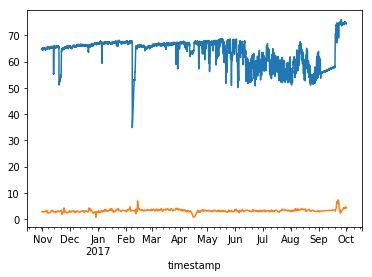

In [69]:
models = {}
cv = TimeSeriesSplit(3)
for ti, (target_name, target) in enumerate(target_pairs):
    print("Таргет:", target_name)
    target = pd.read_csv(target, index_col="timestamp")
    tr_fts = features_tr.join(target)
    tr_fts.target.plot()
    cv_fts = features_cv.join(target)
    gs=RandomizedSearchCV(
                    estimator=xgb_r,
                      param_distributions=params,
                      cv=cv,
                      scoring="neg_mean_squared_error",
                      n_jobs=2,
                      verbose=1,
                    n_iter=10
    )
    gs.fit(tr_fts[train_cols], tr_fts["target"])
    print(gs.best_estimator_)
    models[target_name] = {"model":gs}
    
    #trpr = gs.predict(tr_fts[features_ts.columns])
    cvpr = gs.predict(cv_fts[train_cols])

    print("RMSE на cv тренировочном множестве:", np.sqrt(-1*gs.best_score_))
    print("RMSE на oof множестве:", np.sqrt(mean_squared_error(cv_fts["target"], cvpr)))

    tspr = gs.predict(features_ts)
    submission = pd.DataFrame(tspr, index=features_ts.index, columns=["target"])
    submission.to_csv("baseline_%s.csv" % target_name)    

In [ ]:
"""XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=3, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5) BEST"""

In [44]:
target = pd.read_csv('coke_target.csv', index_col="timestamp")
xgb_best_coke=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)#models['coke']['model'].best_estimator_
xgb_best_coke.fit(features_tr_all[train_cols], target.target[168:])
tspr = xgb_best_coke.predict(features_ts[train_cols])
submission = pd.DataFrame(tspr, index=features_ts.index, columns=["target"])
submission.to_csv("xgb_best_d4_e200_lr005_ra05_rl1_ss05_cs1_clvl08_coke.csv")

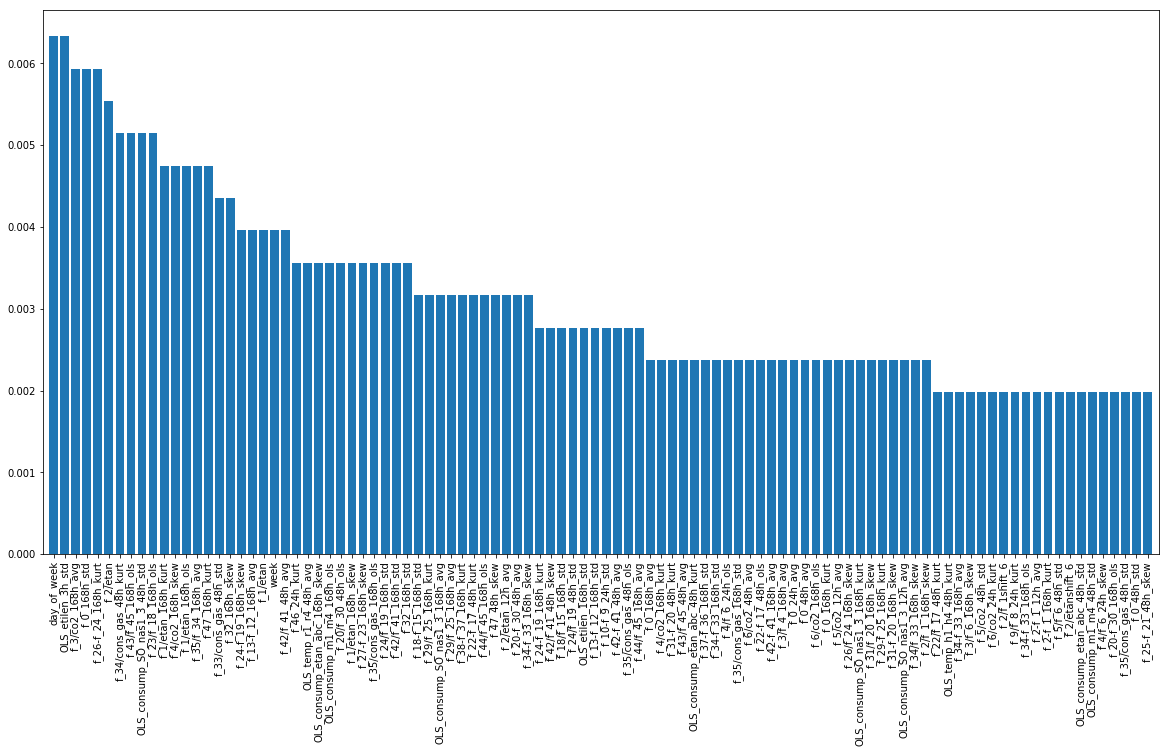

In [45]:
plot_importances(xgb_best_coke, features_tr_all)

In [65]:
target = pd.read_csv('reactor_pressure_target.csv', index_col="timestamp")
xgb_best_pr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.8, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)#models['reactor_pressure']['model'].best_estimator_
xgb_best_pr.fit(features_tr_all[train_cols], target.target[168:])
tspr = xgb_best_pr.predict(features_ts[train_cols])
submission = pd.DataFrame(tspr, index=features_ts.index, columns=["target"])
submission.to_csv("xgb_best_d5_e200_lr01_ra08_rl0_ss05_cl08_clvl08_pressure.csv")

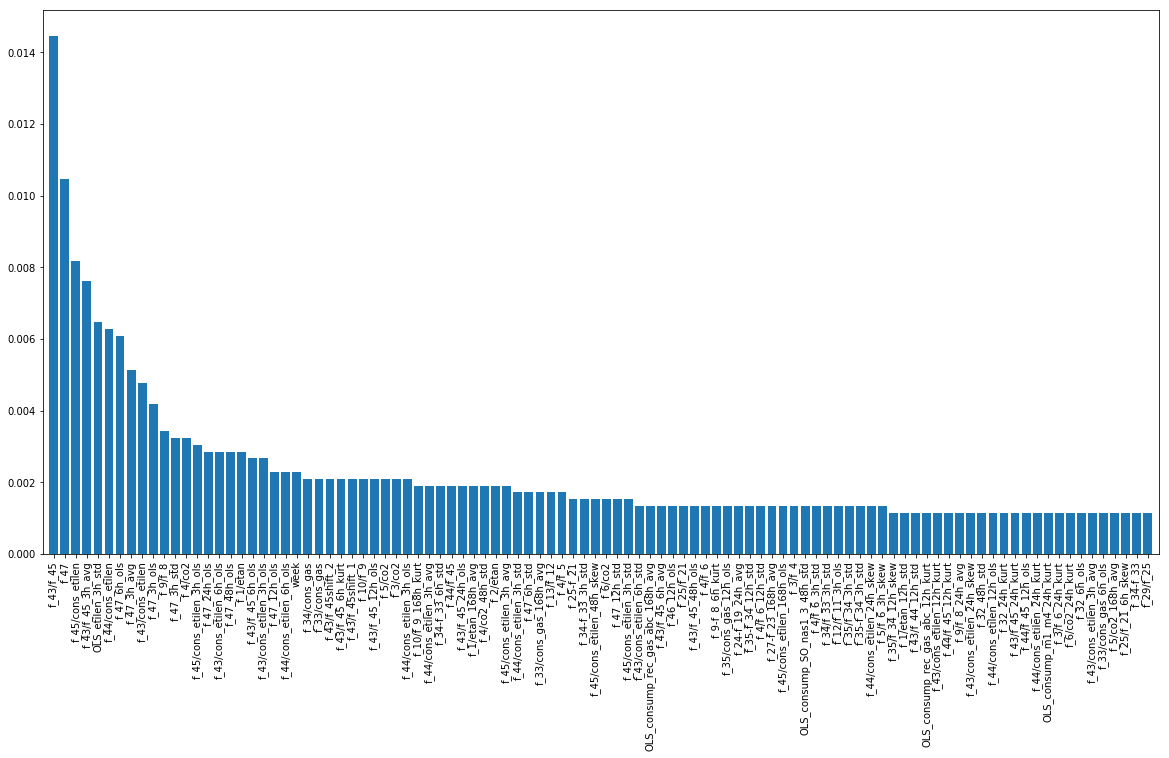

In [66]:
plot_importances(xgb_best_pr, features_tr_all)

### Blend

In [106]:
df_1=pd.read_csv('lgbm_50_mrse_exp005.csv')
df_2=pd.read_csv('blend_lgbm50_48lag_exp005.csv')

In [101]:
df_1['target']=(df_1['target']+df_2['target'])*0.5

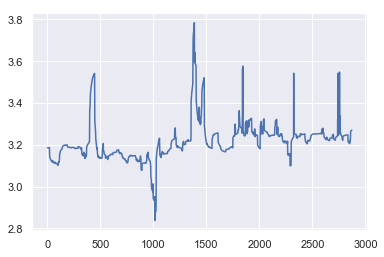

In [102]:
df_1['target'].plot()

In [103]:
df_1[['timestamp','target']].to_csv('blend_lgbm50_48lag_exp005.csv', index=False)